# Down-and-Out Call via Cox–Ross–Rubinstein Tree  
### Barrier Option Pricing & Monte-Carlo Validation

We price a **down-and-out European call** (\(B\) barrier) with:

1. A **binomial-CRR tree** that zeros out payoffs whenever \(S<B\).  
2. A **Monte-Carlo GBM simulation** with knock-out test and 95 % CI.

We then compare both methods side by side.

| Symbol    | Meaning                        | Value         |
|-----------|--------------------------------|---------------|
| \(S_0\)    | Initial spot price            | **100**       |
| \(K\)      | Strike price                  | 100           |
| \(r\)      | Risk-free rate                | 5 %           |
| \(\sigma\) | Volatility                    | 20 %          |
| \(T\)      | Time to maturity (years)      | 1.0           |
| \(B\)      | Down barrier level            | 80            |
| \(N\)      | Binomial steps                | 400           |
| \(M\)      | MC time steps                 | 800           |
| \(N_{\rm paths}\) | MC sample paths        | 200 000       |

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# model parameters
S0, K, r, sigma, T = 100, 100, 0.05, 0.20, 1.0
B = 80

# numerical settings
N_steps = 400  # CRR steps
M_steps = 800  # MC time steps
N_paths = 200_000  # MC sample paths

In [2]:
def binomial_crr_barrier_price(S0, K, B, r, sigma, T, N):
    """
    Down-and-out call via CRR binomial tree.
    Knocked-out whenever asset price <= B at any node.
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    disc = np.exp(-r * dt)

    # terminal asset prices and payoffs
    j = np.arange(N + 1)
    ST = S0 * (u ** (N - j)) * (d**j)
    V = np.where(ST <= B, 0.0, np.maximum(ST - K, 0.0))

    # backward induction with barrier enforcement
    for step in range(N, 0, -1):
        V = disc * (p * V[:step] + (1 - p) * V[1 : step + 1])
        # compute asset prices at this level
        j = np.arange(step)
        S_j = S0 * (u ** (step - j)) * (d**j)
        # knock out
        V = np.where(S_j <= B, 0.0, V)

    return float(V[0])

In [3]:
def mc_down_out_call(S0, K, B, r, sigma, T, M, N_paths, seed=None):
    """
    Down-and-out call via Monte Carlo of GBM with discrete barrier test.
    Returns (price, ci95).
    """
    if seed is not None:
        np.random.seed(seed)

    dt = T / M
    # simulate log‐returns
    Z = np.random.randn(N_paths, M)
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    logS = np.cumsum(increments, axis=1)
    S_paths = S0 * np.exp(logS)

    # barrier test & payoff
    knocked = (S_paths <= B).any(axis=1)
    ST = S_paths[:, -1]
    payoff = np.where(knocked, 0.0, np.maximum(ST - K, 0.0))
    disc_pay = np.exp(-r * T) * payoff

    price = disc_pay.mean()
    stderr = disc_pay.std(ddof=1) / np.sqrt(N_paths)
    ci95 = 1.96 * stderr
    return price, ci95

In [4]:
# price via binomial CRR
price_bin = binomial_crr_barrier_price(S0, K, B, r, sigma, T, N_steps)

# price via Monte Carlo with 95% CI
price_mc, ci_mc = mc_down_out_call(S0, K, B, r, sigma, T, M_steps, N_paths, seed=42)

# display
print(f"Binomial CRR barrier-call price    : {price_bin:.4f}")
print(f"Monte Carlo   barrier-call price   : {price_mc:.4f}  ±{ci_mc:.4f}")

Binomial CRR barrier-call price    : 10.3865
Monte Carlo   barrier-call price   : 10.3203  ±0.0645


### Price Comparison

| Method                      | Price (±95 % CI)      |
|-----------------------------|-----------------------|
| Binomial CRR barrier call   | **10.3865**   |
| Monte Carlo barrier call    | **10.3203**  ±0.0645|

---

### Convergence of Binomial-CRR Barrier Call  
We analyze how the binomial tree price for a barrier option converges as the number of time steps increases. This gives us insights into the stability and efficiency of the method.

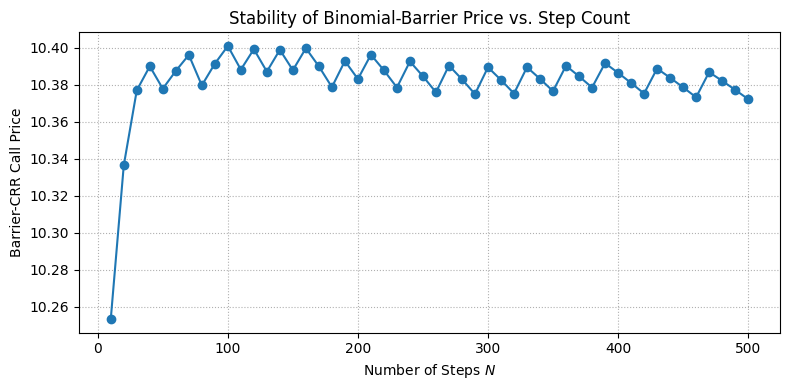

In [5]:
# sweep of step counts
steps = np.arange(10, 501, 10)
prices = [binomial_crr_barrier_price(S0, K, B, r, sigma, T, N) for N in steps]

plt.figure(figsize=(8, 4))
plt.plot(steps, prices, marker="o", linestyle="-")
plt.xlabel("Number of Steps $N$")
plt.ylabel("Barrier-CRR Call Price")
plt.title("Stability of Binomial-Barrier Price vs. Step Count")
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()

### Observations

- The binomial tree price for the up-and-out barrier call option gradually stabilizes as the number of steps increases.
- For barrier options, the convergence is slower than for vanilla options due to the path-dependency introduced by the barrier condition.
- A higher number of steps is required for reliable accuracy, especially when the barrier is close to the current asset price.